In [3]:
# Change the dataset in global_vars.py to NAKO.
from global_vars import *
from commons import *

import glob 
import os

one_time_n4_optimization = True
vol_to_check_list = None #['100025']
exclude = []

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def load_nako_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
        opp_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_opp/**.nii.gz') # **_2**
        in_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_in/**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_F/**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_W/**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths

file_paths = load_nako_file_paths()
file_paths

{'100025': {'VOLUME_PATHS': {'OPP': ['/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100025/100025_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_1.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100025/100025_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_2.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100025/100025_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_3.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100025/100025_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_4.nii.gz'],
   'IN': ['/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100025/100025_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_1_e2.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100025/100025_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_2_e2.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI/100025/100025_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_3_e2.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/NAKO/NAKO_200/MRI

In [5]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [6]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1

In [7]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

started with 100025...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -211.99302673]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -418.03955078]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -211.99302673]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -610.03955078]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -211.99302673]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -838.03955078]
 [   0.            0.            0. 

In [8]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with 100025...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-116.0
neagtive value detected
saving directory: temp/NAKO/n4_corrected_2/vol/100025


In [9]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on stitched opp scans of {vol}...')

    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

applying n4 bias field on stitched opp scans of 100025...
temp/NAKO/n4_corrected_2/vol/100025/OPP_ras_stitched.nii.gz temp/NAKO/n4_corrected_2/vol/100025/IN_ras_stitched_n4_scaled_bias_field.nii.gz
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
saving directory: temp/NAKO/n4_correct

In [10]:
def nako_vol_label_fix(vol, label):
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    final_label = np.zeros(tuple(world_shape))

    label_affine = label.affine
    vol_affine = vol.affine
    
    target_affine = vol_affine
    target_header = vol.header
    target_dim_v = vol.shape

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
    
    final_label[0:ex+sx, 0:ey+sy, sz:ez] = label.get_fdata()
    
    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=1)
    
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    return vol, final_label_img

def nako_label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape

    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        sx,sy,sz,ex,ey,ez = np.abs(get_points(labelmap_img, reference_labelmap))
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
100025
['datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver-2.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right) .nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.niiGallbladder-2.nrrd']
Reading Files.....
Reading NRRD Files.....
Transformi

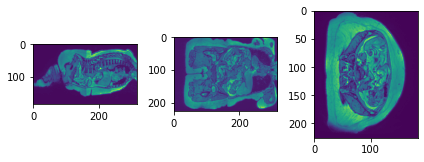

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


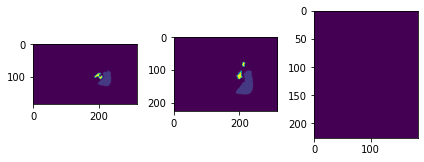

Saving Processed & Stitched Image.....
saving directory: temp/NAKO/processed/volume
saving directory: temp/NAKO/processed/label
FINISHED.


In [11]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = []
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     volume = nb.load(file_paths[vol]['ONE']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        img_ras = makeit_3d(img_ras)
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode='constant', cval=0)
        if labelname == 'SPLEEN':
            later.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
        else:
            img_ras_list.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
    
    img_ras_list.extend(later)
    
    s_label = nako_label_parts(img_ras_list)
    s_label = drop_overlapped_pixels(s_label, np.array(img_ras_list)[:, 1])
    volume, s_label = nako_vol_label_fix(volume, s_label)
    volume = hist_match(volume)

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')